In [1]:
import os
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

In [24]:
sys.path.append(os.path.join("..", "external", "segment-anything"))
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [25]:
# utility functions

def downscale_image(img, max_dim=512):
    original_size = img.shape[:2]  # (H, W)
    height, width = original_size
    scale = max_dim / max(height, width)
    new_width = int(width * scale)
    new_height = int(height * scale)
    downscaled = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return downscaled, original_size

def upscale_image(img, original_size):
    return cv2.resize(img, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)

def generate_boundary_mask(masks, shape):
    """
    Convert SAM masks to a binary mask with black boundaries on white background.
    """
    boundary_mask = np.ones(shape, dtype=np.uint8) * 255  # white background
    for m in masks:
        segmentation = m['segmentation'].astype(np.uint8)
        contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(boundary_mask, contours, -1, color=0, thickness=1)
    return boundary_mask

In [31]:
# load image

image_path = "../test-images-mnz/new_york_city.jpg"
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

image_scaling = False

if image_scaling:
    downscaled_image, original_size = downscale_image(image_bgr)
else:
    downscaled_image, original_size = image_bgr, image_bgr.shape[:2]

downscaled_img_rgb = cv2.cvtColor(downscaled_image, cv2.COLOR_BGR2RGB)

In [32]:
# load segment anything (sam)

model_type = "vit_h"
checkpoint_path = "../models/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [33]:
# generate mask

print("Generating SAM mask...")
print(f"Image scaling: {image_scaling}, image dimensions (h, w): {downscaled_image.shape[:2]}")
masks = mask_generator.generate(downscaled_img_rgb)
print(f"Generated {len(masks)} masks.")


Generating SAM mask...
Image scaling: False, image dimensions (h, w): (2160, 3840)
Generated 174 masks.


In [34]:
# create boundary image
H, W, _ = downscaled_img_rgb.shape
boundary_mask = generate_boundary_mask(masks, (H, W))

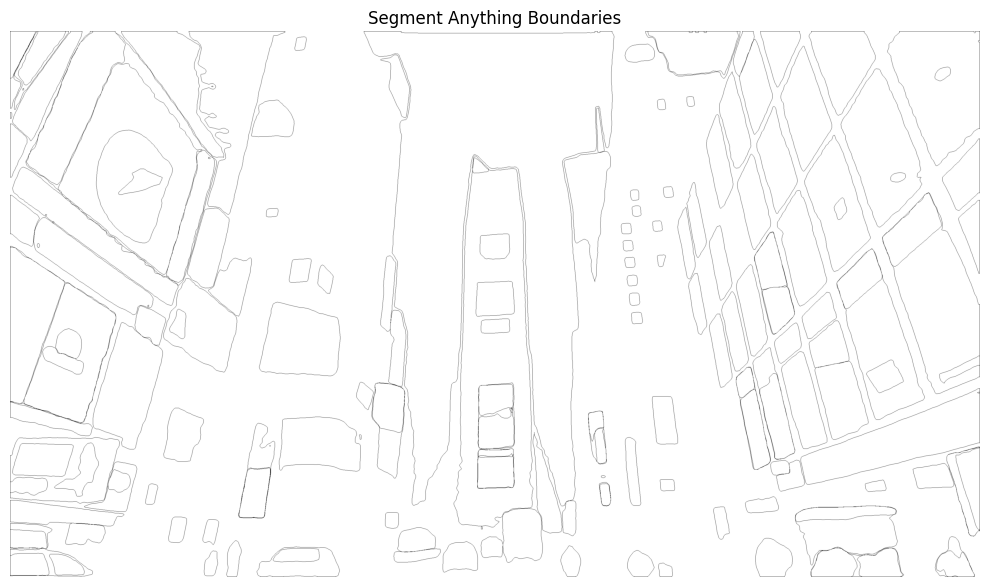

True

In [35]:
# upscale and show
if image_scaling:
    segmented_img_upscaled = upscale_image(boundary_mask, original_size)
else:
    segmented_img_upscaled = boundary_mask

plt.figure(figsize=(10, 10))
plt.imshow(segmented_img_upscaled, cmap='gray')
plt.title("Segment Anything Boundaries")
plt.axis("off")
plt.tight_layout()
plt.show()

# Save the result
cv2.imwrite(f"../target/sam_images/sam_image_2.jpg", segmented_img_upscaled)